## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


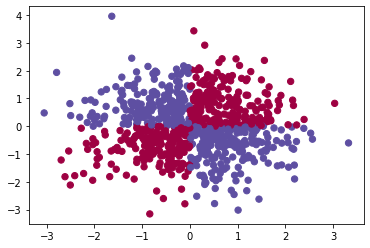

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [5]:
# Q3: You need 2 input nodes and 1 output node

In [6]:
# sigmoid function 

def sigmoid(x):
    return (1/(1+np.e**(-x)))

In [7]:
# RELU function

def RELU(x):
    return np.max((0, x))

In [8]:
# Q 1-2, 4-6

class NeuralNetwork():
    def __init__(self, num_hidden_layers, learning_rate):
        
        # initialize weights
        self.weights = np.random.normal(loc=0.0, scale=0.5, size=4*num_hidden_layers + 1)

        # initialize num hidden layers
        self.K = num_hidden_layers

        # initialize learning rate for training
        self.learning_rate = learning_rate
    
    def forward(self, x):
        # forward pass
        y = 0
        for i in range(self.K):
            j_val = RELU(np.sum([x[j]*self.weights[self.K*(j+1) + i] for j in range(2)]  + self.weights[i]))
            y += self.weights[3*self.K + i + 1]*j_val
        return sigmoid(y + self.weights[3*self.K])

        
    def backward(self, actual, predicted, x_vars):

        # initialize zero values for our gradient 
        gradient = np.zeros(4*self.K + 1)
        
        for t, y, x in zip(actual, predicted, x_vars):
            
            # calculate sigmoid gradient 
            grad_val = (y - t)

            # calculate the activations 
            a = [RELU(np.sum([x[j]*self.weights[self.K*(j+1) + i] for j in range(2)])) + self.weights[i] for i in range(self.K)]

            # calculate the RELU gradients
            grad_a = [1 if val >= 0 else 0 for val in a]

            # gets gradient for biases of layer 1
            gradient[0:self.K] = [grad_val*self.weights[3*self.K + i + 1]*grad_a[i] for i in range(self.K)]

            # gets gradients for weights of layer 1
            for i in range(self.K):
                for j in range(2):
                    gradient[self.K*(j+1) + i] = grad_a[i]*self.weights[3*self.K + i + 1]*grad_val*x[j]

            # gets gradient of bias of layer 2
            gradient[3*self.K] = grad_val

            # gets gradients of weights of layer 2
            gradient[(3*self.K + 1):] = [grad_val*a[i] for i in range(self.K)]
            
        # normalize gradient
        return gradient/len(actual)
        

    def update(self, gradient):
        # update weights 
        self.weights = self.weights - self.learning_rate*gradient

In [9]:
# cross validation (Q7 - 8)

from sklearn.model_selection import train_test_split

learning_rate = 0.1
num_hidden_layers = 16
batch_size = 2
num_iterations = 12000

K = 8 
accuracy_list = []

for i in range(K):
    # train val split
    X_train_cross, X_val_cross, y_train_cross, y_val_cross = train_test_split(
      X_train,y_train, test_size=1/K, shuffle=True)

    # initialize neural network
    my_nn = NeuralNetwork(num_hidden_layers, learning_rate)

    # training loop
    for i in range(num_iterations):
        actual = []
        choices = np.random.choice(range(700), batch_size, replace = False)
        for batch in choices:
            actual.append(y_train_cross[batch])
            predictions = [my_nn.forward(X) for X in X_train_cross[choices]]
        gradient = my_nn.backward(actual, predictions, X_train_cross[choices])
        my_nn.update(gradient)

    # check validation error

    accuracy = 0
    for x, y in zip(X_val_cross, y_val_cross):
        pred = my_nn.forward(x)
        pred = 1 if pred >=0.5 else 0
        if pred == y:
            accuracy += 1
    print(accuracy/100)
    accuracy_list.append(accuracy/100)

print(np.mean(accuracy_list))

0.9
0.97
0.93
0.98
0.9
1.0
0.93
0.99
0.95


In [10]:
# classification report

learning_rate = 0.1
num_hidden_layers = 16
batch_size = 2
num_iterations = 12000

my_nn = NeuralNetwork(num_hidden_layers, 0.1)

# train on chosen hyperparameters

for i in range(12000):
    actual = []
    choices = np.random.choice(range(800), 2, replace = False)
    for batch in choices:
        actual.append(y_train[batch])
        predictions = [my_nn.forward(X) for X in X_train[choices]]
    gradient = my_nn.backward(actual, predictions, X_train[choices])
    my_nn.update(gradient)
    

In [11]:
# test set classification summary

x_pred = []

for x in X_test:
    pred = my_nn.forward(x)
    pred = 1 if pred >=0.5 else 0
    x_pred.append(pred)
    
predictions = np.array(x_pred)
actual = y_test

TP = (predictions == 1) & (actual == 1)
FP = (predictions == 1) & (actual == 0)
TN = (predictions == 0) & (actual == 0)
FN = (predictions == 0) & (actual == 1)

accuracy = (sum(TP) + sum(TN))/len(X_test)
precision = sum(TP)/(sum(TP) + sum(FP))
recall = sum(TP)/(sum(TP) + sum(FN))

print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(2*precision*recall/(precision + recall)))

Accuracy: 0.98
Precision: 0.9714285714285714
Recall: 0.9902912621359223
F1: 0.9807692307692307


In [12]:
# train set classification summary

x_pred = []

for x in X_train:
    pred = my_nn.forward(x)
    pred = 1 if pred >=0.5 else 0
    x_pred.append(pred)
    
predictions = np.array(x_pred)
actual = y_train

TP = (predictions == 1) & (actual == 1)
FP = (predictions == 1) & (actual == 0)
TN = (predictions == 0) & (actual == 0)
FN = (predictions == 0) & (actual == 1)

accuracy = (sum(TP) + sum(TN))/len(X_train)
precision = sum(TP)/(sum(TP) + sum(FP))
recall = sum(TP)/(sum(TP) + sum(FN))

print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1: ' + str(2*precision*recall/(precision + recall)))

Accuracy: 0.94875
Precision: 0.9449760765550239
Recall: 0.9564164648910412
F1: 0.950661853188929


In [13]:
# summary

"""

The neural network is a 2-layer network with 2 input neurons and 1 output neuron and a hidden layer of 16 neurons. Using
k-fold cross validation, I determined that these parameters resulted in better performance. For our test set, our accuracy 
is 98%, which is really good. The recall is 99%, so that means that our model is extremely good at preventing false negatives.
The precision is 97%, slightly worse than the recall, but still extremely good. 

For our train set, it has a lower accuracy. The precision is 94% and recall is 95%, so the performance over false positives 
and negatives are quite even. Overall, this neural network performs quite well in predicting the XOR dataset. 


"""

'\n\nThe neural network is a 2-layer network with 2 input neurons and 1 output neuron and a hidden layer of 16 neurons. Using\nk-fold cross validation, I determined that these parameters resulted in better performance. Over the test set and train set, \nwe had a 92% accuracy, a 87% precision, and a 98% recall. Our model is particularly good at preventing false negatives\nbut does tend to have more false positives, as shown by the 87% precision. \n\n\n'